In [1]:
from sbcbinaryformat import Streamer, Writer
import numpy as np
import matplotlib.pyplot as plt

from GetEvent import GetEvent

from ana import AcousticT0 
from scipy.signal import firwin, filtfilt
import importlib

In [2]:
importlib.reload(AcousticT0)

<module 'ana.AcousticT0' from '/exp/e961/app/users/runze/projects/LAr10Ana/ana/AcousticT0.py'>

In [3]:
TEST_RUN = "/exp/e961/data/SBC-25-daqdata/20250611_1/"
#TEST_RUN2 = "/exp/e961/app/users/runze/data/20251103_1/"
TEST_RUN2 = "/exp/e961/data/users/gputnam/SBC-25-daqdata-test/20251103_1/"
TEST_EVT = 0

In [4]:
data = GetEvent(TEST_RUN2, TEST_EVT,strictMode=False)

/exp/e961/app/users/runze/projects/LAr10Ana/GetEvent.py:106: UserWarning: No scintillation file present in the run directory. Data will not be available in the returned dictionary.
  warnings.warn("No scintillation file present in the run directory. Data will not be available in the returned dictionary.")
/exp/e961/app/users/runze/projects/LAr10Ana/GetEvent.py:214: UserWarning: No run_info file present in the run directory. Data will not be available in the returned dictionary.
  warnings.warn("No run_info file present in the run directory. Data will not be available in the returned dictionary.")


In [5]:
data["acoustics"].keys()

dict_keys(['loaded', 'Range', 'DCOffset', 'Waveforms', 'sample_rate'])

In [6]:
data["acoustics"]["Range"]


array([[ 2000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]],
      dtype=int16)

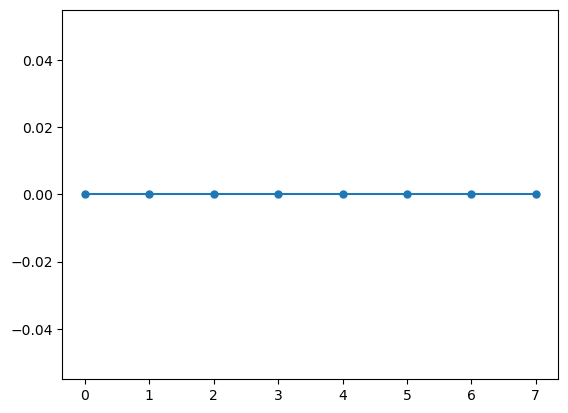

In [7]:
# DC Offset by channel
_ = plt.plot(data["acoustics"]["DCOffset"][0], marker=".", markersize=10)

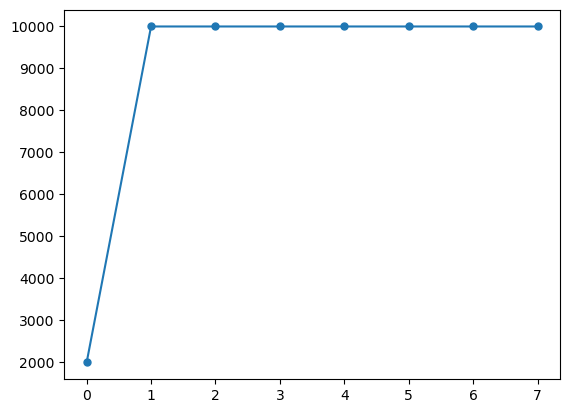

In [8]:
# DC Offset by channel
_ = plt.plot(data["acoustics"]["Range"][0], marker=".", markersize=10)

In [9]:
wvfs = data["acoustics"]["Waveforms"]
wvfs.shape

(1, 8, 450001)

In [10]:
np.float64([[1e2, 1e3, 1e4, 1e5]]).shape

(1, 4)

Text(0, 0.5, 'pressure/psi')

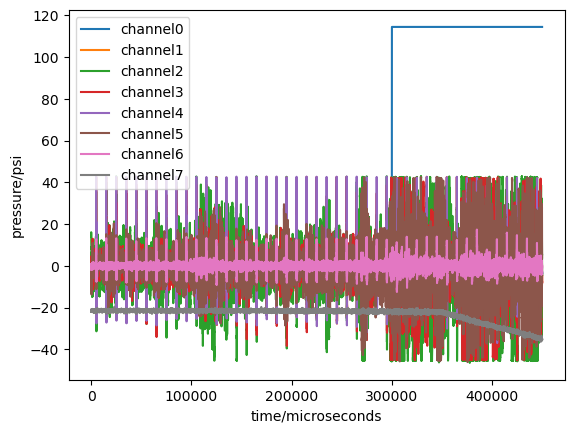

In [40]:
# plot the first triggered waveform in each channel
# if channel 7 raw reading is ADC -35/1e4
# if channel 7 raw reading is bits, -35/2**15
# MB.PT1101 := AIn.PT1101 * (-35.0* el3052bits);
#wvfs_psi = wvfs*(35/2**15)
wvfs_psi = wvfs*(35/1e4)

for channel in range(wvfs.shape[1]):
    plt.plot(wvfs_psi[0, channel, :],label="channel"+str(channel))
    #plt.plot(wvfs[0, channel, :],label="channel"+str(channel))
plt.legend()
plt.xlabel("time/microseconds")
plt.ylabel("pressure/psi")
# channel 0 hydraulic trigger 15bits
# channel 1-6 acoustic
# channel 7, PT 
# that is when compress happens, and with a delay, the pressure drops

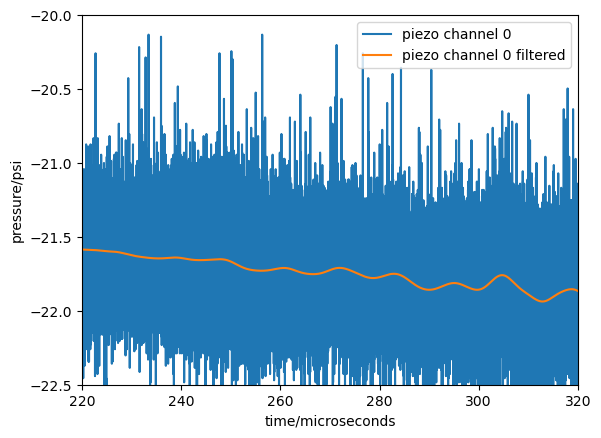

In [45]:
piezo0 = wvfs_psi[0, 7, :]
xlimit = [220,320]
ylimit = [-22.5,-20]
# time in miliseconds
total_time = len(piezo0)
time_list_ms = [i/1e3 for i in range(0,total_time,1)]

# add low pass filter
# assuming 1 microsecond time resolution 1e6Hz
numtaps = 5000  # filter length (longer = sharper cutoff)
Fs= 1000000 # sampling rate
Fc = 10 # low pass filter in Hz
fir = firwin(numtaps, Fc, window='hamming', fs=Fs)

piezo0_filtered = filtfilt(fir, [1.0], piezo0)
piezoslope0 = -piezo0_filtered[1:]+piezo0_filtered[:-1]
plt.plot(time_list_ms,piezo0, label="piezo channel 0")
plt.plot(time_list_ms,piezo0_filtered, label="piezo channel 0 filtered")
plt.xlabel("time/microseconds")
plt.ylabel("pressure/psi")
plt.xlim(xlimit)
plt.ylim(ylimit)
plt.legend()

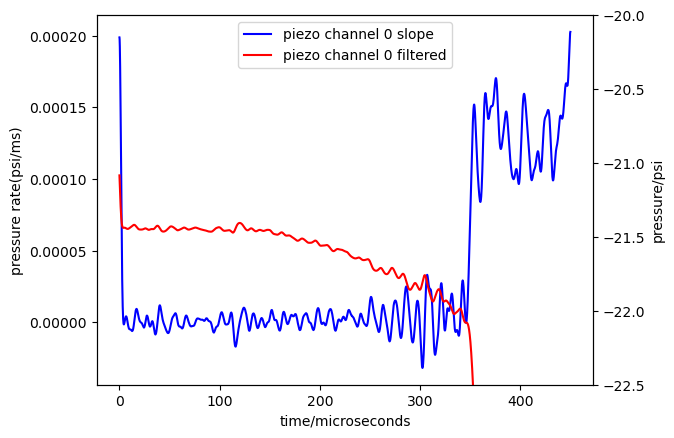

In [61]:
fig, ax1 = plt.subplots()

# First axis
l1 = ax1.plot(time_list_ms[:-1],piezoslope0, label="piezo channel 0 slope",color="blue")
ax1.set_xlabel("time/microseconds")
ax1.set_ylabel("pressure rate(psi/ms)")
# ax1.tick_params(axis='y', labelcolor="blue")

# Second axis (shares X)
ax2 = ax1.twinx()
l2 = ax2.plot(time_list_ms,piezo0_filtered, label="piezo channel 0 filtered",color="red")
ax2.set_ylabel("pressure/psi")
ax2.set_ylim(ylimit)

lines = l1 + l2
labels = [line.get_label() for line in lines]

ax1.legend(lines, labels)
# plt.legend()

In [71]:
#quadratic fittings
# finding ending point, hard cut, find first time when the rate > 1e-4 psi/ms
# starting point, from [10:]
# then fitting find t0

starting_indx = 10000
# starting 10ms after data collection
print(piezoslope0[starting_indx])
ending_indx = 0
hardcut_threshold = 1e-4
for i in range(starting_indx,len(piezoslope0),1):
    if piezoslope0[i] > hardcut_threshold:
        ending_indx = i
        
        break
# print("index",ending_indx)
pressure_before_fit = piezo0_filtered[starting_indx:ending_indx]
time_fit_range = time_list_ms[starting_indx:ending_indx]

-4.7150609567836455e-06


In [87]:
#qua fit
coeffs = np.polyfit(time_fit_range, pressure_before_fit, 2)
a, b, c = coeffs
print(a, b, c)

# find t0
t0_fitted = round(-b/(2*a),3)

-8.689397607985347e-06 0.0014091974927256247 -21.48722019563435


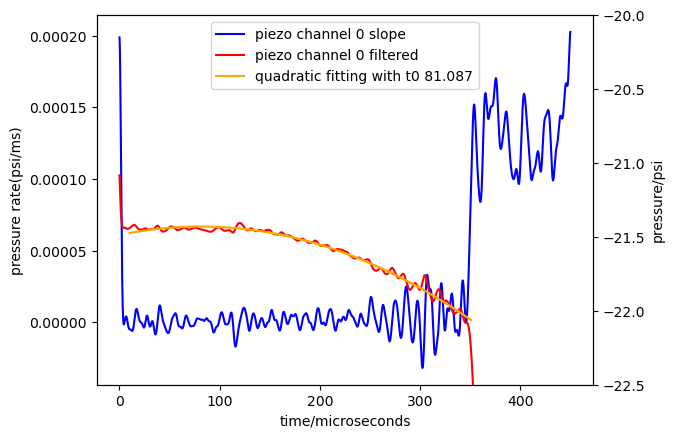

In [88]:
# generate the fitting and plot it in the same graph
qua_fitting = [round(a*i**2+b*i+c,3) for i in time_fit_range]


fig, ax1 = plt.subplots()

# First axis
l1 = ax1.plot(time_list_ms[:-1],piezoslope0, label="piezo channel 0 slope",color="blue")
ax1.set_xlabel("time/microseconds")
ax1.set_ylabel("pressure rate(psi/ms)")
# ax1.tick_params(axis='y', labelcolor="blue")



# Second axis (shares X)
ax2 = ax1.twinx()
l2 = ax2.plot(time_list_ms,piezo0_filtered, label="piezo channel 0 filtered",color="red")
# quadratic fitting
l3 = ax2.plot(time_fit_range,qua_fitting, label="quadratic fitting with t0 "+str(t0_fitted),color="orange")
ax2.set_ylabel("pressure/psi")
ax2.set_ylim(ylimit)

lines = l1 + l2+ l3
labels = [line.get_label() for line in lines]

ax1.legend(lines, labels)